In [1]:
!pip install transformers[torch] datasets -q

In [2]:
!pip install rouge_score evaluate -q

In [3]:
import requests
from PIL import Image
from io import BytesIO
import torch
from torchvision import transforms
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from collections import Counter
from datasets import load_metric

2024-05-20 12:15:58.500694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 12:15:58.500801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 12:15:58.626648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading data

In [5]:
dataset = load_dataset("flaviagiammarino/path-vqa")

Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})

Question: what are stained here with an immunohistochemical stain for cytokeratin 7?
Answer: bile duct cells and canals of hering


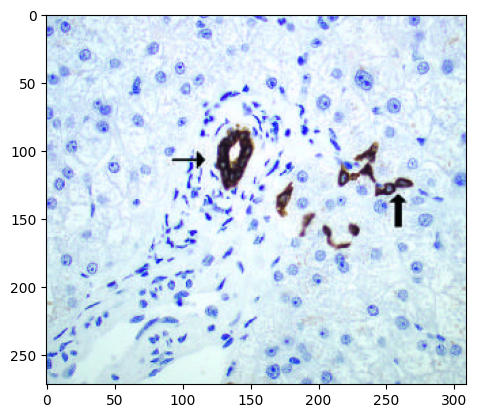

In [7]:
sample = dataset['train'][1]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [8]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

In [9]:
train_data = dataset['train'].select(range(15000))
val_data = dataset['validation'].select(range(1500))
test_data = dataset['test'].select(range(1500))

In [10]:
print(len(train_data['answer']))


15000


In [11]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

In [12]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [13]:
print(len(text_processor.tokenizer.get_vocab()))

30522


In [14]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter

# Initialize the tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Initialize the counter
token_counter = Counter()

# Iterate over your dataset
for idx in range(len(val_data)):
    item = val_data[idx]
    # Tokenize the text and update the counter
    token_counter.update(tokenizer.tokenize(item['answer']))
    token_counter.update(tokenizer.tokenize(item['question']))

for idx in range(len(train_data)):
    item = train_data[idx]
    # Tokenize the text and update the counter
    token_counter.update(tokenizer.tokenize(item['answer']))
    token_counter.update(tokenizer.tokenize(item['question']))

# Get the set of tokens in the tokenizer's vocabulary
vocab_tokens = set(text_processor.tokenizer.get_vocab().keys())

# Find the difference between the sets of tokens
unknown_tokens = set(token_counter.keys()) - vocab_tokens

# Add the unknown tokens to the tokenizer
text_processor.tokenizer.add_tokens(list(unknown_tokens))


2016

In [15]:
print(unknown_tokens)
print(len(unknown_tokens))

{'b67', 'crookes', 'fluorescein', 'unicystic', '18yo', 'theca', 'macrovesicles', 'hemispheres', 'clefts', 'abscesses', 'neuropathy', 'dilantin', 'glomus', 'permeability', 'varices', 'aphthous', 'cribriform', 'equipments', 'pyriform', 'osteoclast', 'sella', 'perforation', 'collagens', 'fibrous', 'gallbladder', 'venogram', 'cryptococcal', 'eosinophils', 'cd34', 'hemosiderin', 'foamy', 'exposes', 'starry', 'necrotizing', 'chorionic', 'articular', 'submaxillary', 'peritonitis', 'fibroblasts', 'ameloblastom', 'myocytolysis', 'thinning', 'haemosiderin', 'leventhal', 'ulcers', 'spindle', 'lewy', 'anemia', 'fibrosis', 'entangled', 'collagen', 'erythroplakia', 'pemphigoid', 'vegetations', 'peribronchial', 'pleural', 'steroid', 'multilocular', 'nephron', 'perilously', 'ghon', 'seborrheic', 'caseating', 'ureter', 'arachnodactyly', 'germline', 'fibroma', 'cd4', 'cystadenoma', 'granular', 'spleens', 'warthins', 'photomicrograph', 'mainstbronchus', 'stillbirth', 'pyelitis', 'histone', 'postmortexten

In [16]:
print(len(text_processor.tokenizer.get_vocab()))

32538


In [17]:
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=val_data,
                     segment='validation',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )
test_vqa_dataset = VQADataset(data=test_data,
                     segment='test',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )


In [18]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)
test_dataloader = DataLoader(test_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [19]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)


input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


#Build Model

In [20]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )


model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [21]:
# # Get the current embeddings
# current_embeddings = model.text_encoder.embeddings.word_embeddings.weight

# # Define new vocabulary size
# new_vocab_size = len(text_processor.tokenizer)

# # Create new embeddings
# new_embeddings = torch.nn.Embedding(new_vocab_size, current_embeddings.shape[1])

# # Copy the old weights into the new embeddings
# with torch.no_grad():
#     new_embeddings.weight[:current_embeddings.shape[0]] = current_embeddings

# # Replace the old embeddings with the new embeddings
# model.text_encoder.embeddings.word_embeddings = new_embeddings


In [22]:
import torch
import torch.nn.functional as F

# Get the current embeddings
current_embeddings = model.text_encoder.embeddings.word_embeddings.weight

# Define new vocabulary size
new_vocab_size = len(text_processor.tokenizer)

# Create new embeddings with the same embedding dimension
new_embeddings = torch.nn.Embedding(new_vocab_size, current_embeddings.shape[1])

# Copy the old weights into the new embeddings
with torch.no_grad():
    new_embeddings.weight[:current_embeddings.shape[0]] = current_embeddings
    
    # Initialize new embeddings with a normal distribution and normalize them
    new_embeddings.weight[current_embeddings.shape[0]:] = F.normalize(
        torch.randn(new_vocab_size - current_embeddings.shape[0], current_embeddings.shape[1]),
        dim=1
    )

# Replace the old embeddings with the new embeddings
model.text_encoder.embeddings.word_embeddings = new_embeddings


In [23]:
# # Get the current embeddings
# current_embeddings = model.text_decoder.bert.embeddings.word_embeddings.weight

# # Define new vocabulary size
# new_vocab_size = len(text_processor.tokenizer)

# # Create new embeddings
# new_embeddings = torch.nn.Embedding(new_vocab_size, current_embeddings.shape[1])

# # Copy the old weights into the new embeddings
# with torch.no_grad():
#     new_embeddings.weight[:current_embeddings.shape[0]] = current_embeddings

# # Replace the old embeddings with the new embeddings
# model.text_decoder.bert.embeddings.word_embeddings = new_embeddings


In [24]:
import torch
import torch.nn.functional as F

# Get the current embeddings
current_embeddings = model.text_decoder.bert.embeddings.word_embeddings.weight

# Define new vocabulary size
new_vocab_size = len(text_processor.tokenizer)

# Create new embeddings with the same embedding dimension
new_embeddings = torch.nn.Embedding(new_vocab_size, current_embeddings.shape[1])

# Copy the old weights into the new embeddings
with torch.no_grad():
    new_embeddings.weight[:current_embeddings.shape[0]] = current_embeddings
    
    # Initialize new embeddings with a normal distribution and normalize them
    new_embeddings.weight[current_embeddings.shape[0]:] = F.normalize(
        torch.randn(new_vocab_size - current_embeddings.shape[0], current_embeddings.shape[1]),
        dim=1
    )

# Replace the old embeddings with the new embeddings
model.text_decoder.bert.embeddings.word_embeddings = new_embeddings



In [25]:
# # Get the current weights
# current_weights = model.text_decoder.cls.predictions.decoder.weight

# # Define new vocabulary size
# new_vocab_size = len(text_processor.tokenizer)

# # Create new linear layer
# new_linear = torch.nn.Linear(current_weights.shape[1], new_vocab_size)

# # Copy the old weights into the new linear layer
# new_linear.weight.data[:current_weights.shape[0]] = current_weights.data

# # Replace the old linear layer with the new linear layer
# model.text_decoder.cls.predictions.decoder = new_linear


In [26]:
import torch
import torch.nn.functional as F

# Get the current weights
current_weights = model.text_decoder.cls.predictions.decoder.weight

# Define new vocabulary size
new_vocab_size = len(text_processor.tokenizer)

# Create new linear layer
new_linear = torch.nn.Linear(current_weights.shape[1], new_vocab_size)

# Copy the old weights into the new linear layer
with torch.no_grad():
    new_linear.weight.data[:current_weights.shape[0]] = current_weights.data
    
    # Initialize new weights with a normal distribution and normalize them
    new_linear.weight.data[current_weights.shape[0]:] = F.normalize(
        torch.randn(new_vocab_size - current_weights.shape[0], current_weights.shape[1]),
        dim=1
    )

# Replace the old linear layer with the new linear layer
model.text_decoder.cls.predictions.decoder = new_linear

print("Linear layer weights have been successfully extended and initialized with normalization.")


Linear layer weights have been successfully extended and initialized with normalization.


In [27]:
model.config.vocab_size = len(text_processor.tokenizer)

In [28]:
model.text_decoder.config.vocab_size = len(text_processor.tokenizer)

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] what are stained here with an immunohistochemical stain for cytokeratin 7? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] bile duct cel ls and cana ls of hering [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


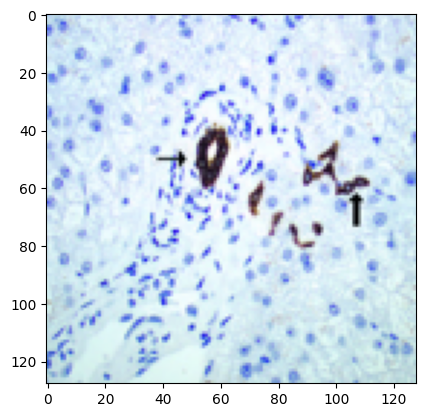

In [30]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [31]:
print(model)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [32]:
# model.to(device)
# model.train()
# for epoch in range(90):
#     print(f"Epoch: {epoch+1}")
#     total_loss = []
#     for batch in tqdm(train_dataloader):
#         # get the inputs;
#         batch = {k:v.to(device) for k,v in batch.items()}
#         # batch['input_ids'] = batch['input_ids'].view(64, -1)
#         # zero the parameter gradients
#         optimizer.zero_grad()
#         # forward + backward + optimize
#         outputs = model(**batch)
#         loss = outputs.loss
#         total_loss.append(loss.item())
#         loss.backward()
#         optimizer.step()
        
#     avg_train_loss = sum(total_loss) / len(total_loss)
#     print(f"Average Training Loss: {avg_train_loss}")
# #     print("Loss:", sum(total_loss))

In [33]:
# model.eval()
# with torch.no_grad():
#     batch = next(iter(val_dataloader))
#     batch = {k: v.to(device) for k, v in batch.items()}
#     outputs = model(**batch)
#     print(outputs)

In [34]:
# # Save model
# model.save_pretrained("./blip-vqa-model")
# text_processor.save_pretrained("./blip-vqa-processor")

In [35]:
# import evaluate
# # Load metrics
# bleu_metric = evaluate.load("bleu")
# rouge_metric = evaluate.load("rouge")

# # Function to calculate exact match
# def exact_match(predictions, references):
#     return np.mean([pred == ref for pred, ref in zip(predictions, references)])
# # Evaluation function with additional metrics
# def evaluate_model(model, val_dataloader, processor, device):
#     model.eval()
#     total_eval_loss = 0
#     predictions = []
#     true_labels = []
#     bleu_scores = []
#     exact_matches = []

#     with torch.no_grad():
#         for batch in tqdm(val_dataloader):
#             batch = {k: v.to(device) for k, v in batch.items()}
#             outputs = model(**batch)
#             loss = outputs.loss
#             total_eval_loss += loss.item()

#             generated_ids = model.generate(pixel_values=batch['pixel_values'], input_ids=batch['input_ids'])
#             preds = [processor.decode(g, skip_special_tokens=True) for g in generated_ids]
#             labels = [processor.decode(l, skip_special_tokens=True) for l in batch['labels']]

#             predictions.extend(preds)
#             true_labels.extend(labels)

#             # Calculate BLEU score
#             for pred, label in zip(preds, labels):
#                 bleu_scores.append(sentence_bleu([label.split()], pred.split()))

#             # Calculate Exact Match
#             exact_matches.extend([pred == label for pred, label in zip(preds, labels)])

#     avg_val_loss = total_eval_loss / len(val_dataloader)
#     avg_bleu_score = np.mean(bleu_scores)
#     avg_exact_match = np.mean(exact_matches)

#     # Compute metrics using evaluate library
#     rouge_result = rouge_metric.compute(predictions=predictions, references=true_labels)

#     print(f"Average Validation Loss: {avg_val_loss}")
#     print(f"BLEU Score: {avg_bleu_score}")
#     print(f"Exact Match: {avg_exact_match}")
#     print(f"ROUGE-1 Score: {rouge_result['rouge1']}")
#     print(f"ROUGE-L Score: {rouge_result['rougeL']}")

#     return {
#         "loss": avg_val_loss,
#         "bleu": avg_bleu_score,
#         "exact_match": avg_exact_match,
#         "rouge1": rouge_result['rouge1'],
#         "rougeL": rouge_result['rougeL'],
#     }


In [36]:
# metrics = evaluate_model(model, val_dataloader, text_processor, device)

In [37]:
import evaluate
from torch.utils.data import Subset
# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Function to calculate exact match
# def exact_match(predictions, references):
#     return np.mean([pred == ref for pred, ref in zip(predictions, references)])

# Evaluation function with additional metrics
def evaluate_model(model, val_dataloader, text_processor, device):
    model.eval()
    total_eval_loss = 0
    predictions = []
    true_labels = []
    bleu_scores = []
    exact_matches = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_eval_loss += loss.item()

            generated_ids = model.generate(pixel_values=batch['pixel_values'], input_ids=batch['input_ids'])
            preds = [text_processor.decode(g, skip_special_tokens=True) for g in generated_ids]
            labels = [text_processor.decode(l, skip_special_tokens=True) for l in batch['labels']]

            predictions.extend(preds)
            true_labels.extend(labels)

            # Calculate BLEU score
            for pred, label in zip(preds, labels):
                bleu_scores.append(sentence_bleu([label.split()], pred.split()))

            # Calculate Exact Match
            exact_matches.extend([pred == label for pred, label in zip(preds, labels)])

    avg_val_loss = total_eval_loss / len(val_dataloader)
    avg_bleu_score = np.mean(bleu_scores)
#     avg_exact_match = np.mean(exact_matches)

    # Compute metrics using evaluate library
    rouge_result = rouge_metric.compute(predictions=predictions, references=true_labels)

    print(f"Average Validation Loss: {avg_val_loss}")
    print(f"BLEU Score: {avg_bleu_score}")
#     print(f"Exact Match: {avg_exact_match}")
    print(f"ROUGE-1 Score: {rouge_result['rouge1']}")
    print(f"ROUGE-L Score: {rouge_result['rougeL']}")

    return {
        "loss": avg_val_loss,
        "bleu": avg_bleu_score,
#         "exact_match": avg_exact_match,
        "rouge1": rouge_result['rouge1'],
        "rougeL": rouge_result['rougeL'],
    }

# Subset for evaluation (e.g., 10% of the validation dataset)
eval_indices = list(range(0, len(val_dataloader.dataset), 10))
eval_subset = Subset(val_dataloader.dataset, eval_indices)
eval_dataloader = DataLoader(eval_subset, batch_size=val_dataloader.batch_size)

model.to(device)
model.train()

for epoch in range(5):
    print(f"Epoch: {epoch + 1}")
    total_loss = []
    
    for batch in tqdm(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    avg_train_loss = sum(total_loss) / len(total_loss)
    print(f"Average Training Loss: {avg_train_loss}")
    
    # Evaluate every 5 epochs
    if (epoch + 1) % 5 == 0:
        metrics = evaluate_model(model, eval_dataloader,text_processor, device)
        print(f"Metrics after epoch {epoch + 1}: {metrics}")

Epoch: 1


  0%|          | 0/235 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Average Training Loss: 1.9087427491203268
Epoch: 2


  0%|          | 0/235 [00:00<?, ?it/s]

Average Training Loss: 0.3013660435029801
Epoch: 3


  0%|          | 0/235 [00:00<?, ?it/s]

Average Training Loss: 0.24700121404008663
Epoch: 4


  0%|          | 0/235 [00:00<?, ?it/s]

Average Training Loss: 0.2015605886090309
Epoch: 5


  0%|          | 0/235 [00:00<?, ?it/s]

Average Training Loss: 0.17140106617453252


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average Validation Loss: 0.38284386197725934
BLEU Score: 0.22806115838178642
ROUGE-1 Score: 0.1756349206349207
ROUGE-L Score: 0.17380952380952389
Metrics after epoch 5: {'loss': 0.38284386197725934, 'bleu': 0.22806115838178642, 'rouge1': 0.1756349206349207, 'rougeL': 0.17380952380952389}


# Inference

Question:  what have lost their nuclei?
Predicted Answer:  the left ventricle
Actual Answer:  neutrophils


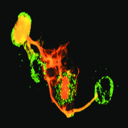

###################################################################
Question:  whose nuclei have been lost?
Predicted Answer:  the
Actual Answer:  neutrophils


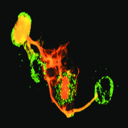

###################################################################
Question:  are two small pulmonary arterioles packed with laminated swirls of fetal squamous cel ls?
Predicted Answer:  no
Actual Answer:  yes


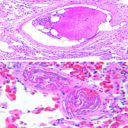

###################################################################
Question:  what is acute viral hepatitis characterize d by?
Predicted Answer:  the left ventricle
Actual Answer:  predominantly lymphocytic infiltra te


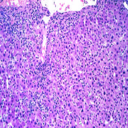

###################################################################
Question:  what do the cel ls have?
Predicted Answer:  the left ventricle
Actual Answer:  wavy nuclei


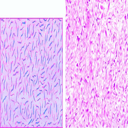

###################################################################
Question:  do the cel ls have wavy nuclei?
Predicted Answer:  no
Actual Answer:  yes


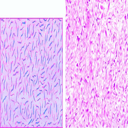

###################################################################
Question:  do individual myocardial fibres have wavy nuclei?
Predicted Answer:  no
Actual Answer:  no


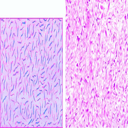

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


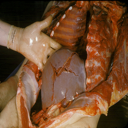

###################################################################
Question:  what does this image show?
Predicted Answer:  the left ventricle
Actual Answer:  peritoneal carcinomatosis


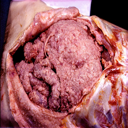

###################################################################
Question:  does this image show peritoneal carcinomatosis, metastatic tumor covering all of the a bdominal viscera?
Predicted Answer:  no
Actual Answer:  yes


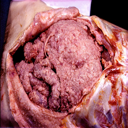

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


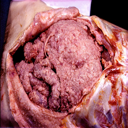

###################################################################
Question:  what does this image show?
Predicted Answer:  the left ventricle
Actual Answer:  hemorrhage secondary to ruptured aneurysm


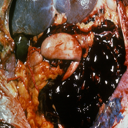

###################################################################
Question:  does this image show hemorrhage secondary to ruptured aneurysm?
Predicted Answer:  no
Actual Answer:  yes


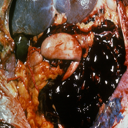

###################################################################
Question:  does abdomen show hemorrhage secondary to ruptured aneurysm?
Predicted Answer:  no
Actual Answer:  no


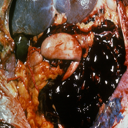

###################################################################
Question:  how is acute viral hepatitis characterize d?
Predicted Answer:  4
Actual Answer:  by predominantly lymphocytic infiltra te


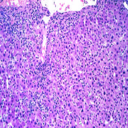

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


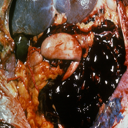

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


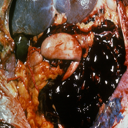

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


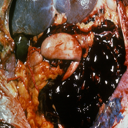

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


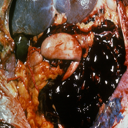

###################################################################
Question:  why does this image show bowel in situ with diffuse thickening of peritoneal surfaces?
Predicted Answer:  due to diabetes mellitus
Actual Answer:  due to metastatic carcinoma breast primary i think


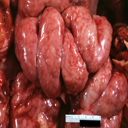

###################################################################
Question:  what does this image show?
Predicted Answer:  the left ventricle
Actual Answer:  bowel in situ with diffuse thickening of peritoneal surfaces due to metastatic carcinoma breast primary i think


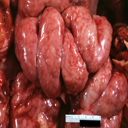

###################################################################
Question:  how does this image show bowel in situ?
Predicted Answer:  with
Actual Answer:  with diffuse thickening of peritoneal surfaces due to metastatic carcinoma breast primary i think


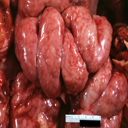

###################################################################
Question:  does this image show bowel in situ with diffuse thickening of peritoneal surfaces due to metastatic carcinoma breast primary i think?
Predicted Answer:  no
Actual Answer:  yes


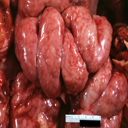

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


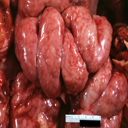

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


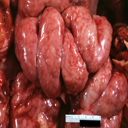

###################################################################
Question:  is acute viral hepatitis characterize by a predominantly lymphocytic infiltra te?
Predicted Answer:  no
Actual Answer:  yes


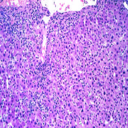

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


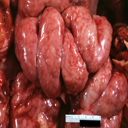

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


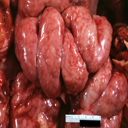

###################################################################
Question:  when does this image show a photo taken?
Predicted Answer:  after orchiectomy
Actual Answer:  during life large lesion


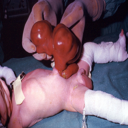

###################################################################
Question:  what does this image show?
Predicted Answer:  the left ventricle
Actual Answer:  a photo taken during life large lesion


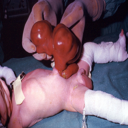

###################################################################
Question:  does this image show a photo taken during life large lesion?
Predicted Answer:  no
Actual Answer:  yes


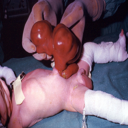

###################################################################
Question:  does omphalocele show a photo taken during life large lesion?
Predicted Answer:  no
Actual Answer:  no


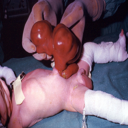

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


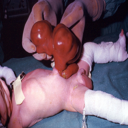

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


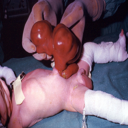

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  omphalocele


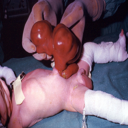

###################################################################
Question:  is omphalocele present?
Predicted Answer:  no
Actual Answer:  yes


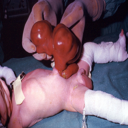

###################################################################
Question:  is the entire thickness of the epithelium characterize by a predominantly lymphocytic infiltra te?
Predicted Answer:  no
Actual Answer:  no


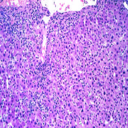

###################################################################
Question:  is omentum present?
Predicted Answer:  no
Actual Answer:  no


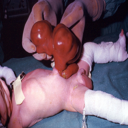

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


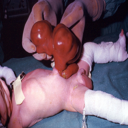

###################################################################
Question:  what taken during life large lesion?
Predicted Answer:  the left ventricle
Actual Answer:  a photo


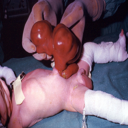

###################################################################
Question:  what is a photo taken?
Predicted Answer:  the left ventricle
Actual Answer:  during life large lesion


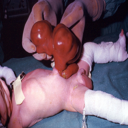

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


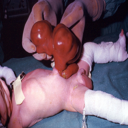

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  omphalocele


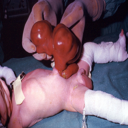

###################################################################
Question:  how is a photo taken during life lesion?
Predicted Answer:  4
Actual Answer:  large


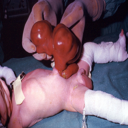

###################################################################
Question:  what does this image show?
Predicted Answer:  the left ventricle
Actual Answer:  fixed tissue typical appearance of tuberculous peritonitis except for color being off a bit


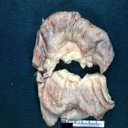

###################################################################
Question:  does this image show fixed tissue typical appearance of tuberculous peritonitis except for color being off a bit?
Predicted Answer:  no
Actual Answer:  yes


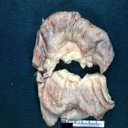

###################################################################
Question:  does acute peritonitis show fixed tissue typical appearance of tuberculous peritonitis except for color being off a bit?
Predicted Answer:  no
Actual Answer:  no


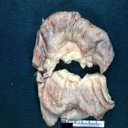

###################################################################
Question:  is schematic diagram of intimal thickening emphasize intimal smooth muscle cell migration and proliferation associated with extracellular matrix synthesis?
Predicted Answer:  no
Actual Answer:  yes


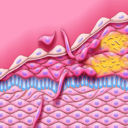

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


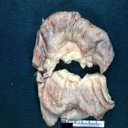

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


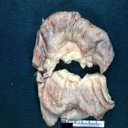

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


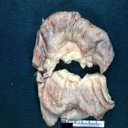

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


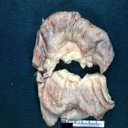

###################################################################
Question:  what does this image show?
Predicted Answer:  the left ventricle
Actual Answer:  close - up view of metastatic lesion s color not the best papillary serous adenocarcinoma of ovary


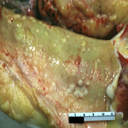

###################################################################
Question:  does this image show close - up view of metastatic lesion s color not the best papillary serous adenocarcinoma of ovary?
Predicted Answer:  no
Actual Answer:  yes


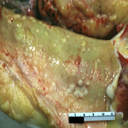

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


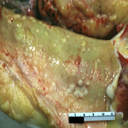

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


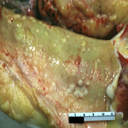

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  peritoneum


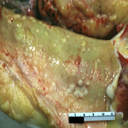

###################################################################
Question:  is peritoneum present?
Predicted Answer:  no
Actual Answer:  yes


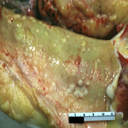

###################################################################
Question:  did n uclear pleomorphism emphasize intimal smooth muscle cell migration and proliferation associated with extracellular matrix synthesis?
Predicted Answer:  no
Actual Answer:  no


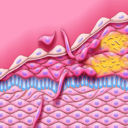

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


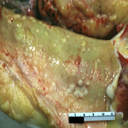

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


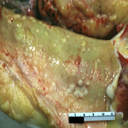

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  peritoneum


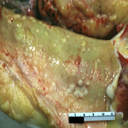

###################################################################
Question:  does this image show opened abdomen with ischemic appearing intestines bound by neoplastic adhesions good but not the best ovarian papillary adenocarcinoma?
Predicted Answer:  no
Actual Answer:  yes


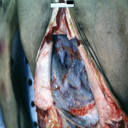

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


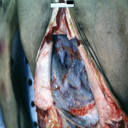

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


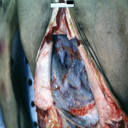

###################################################################
Question:  is tuberculous peritonitis present?
Predicted Answer:  no
Actual Answer:  no


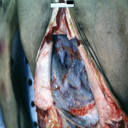

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  peritoneum


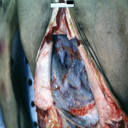

###################################################################
Question:  is peritoneum present?
Predicted Answer:  no
Actual Answer:  yes


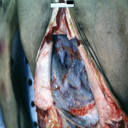

###################################################################
Question:  is an opened peritoneal cavity cause by fibrous band strangulation present?
Predicted Answer:  no
Actual Answer:  no


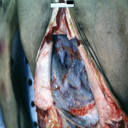

###################################################################
Question:  what is moderately narrowed by this eccentric lesion?
Predicted Answer:  the left ventricle
Actual Answer:  the lumen


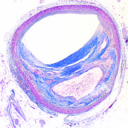

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


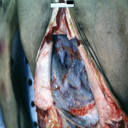

###################################################################
Question:  what bound by neoplastic adhesions good but not the best ovarian papillary adenocarcinoma?
Predicted Answer:  the left ventricle
Actual Answer:  opened abdomen with ischemic appearing intestines


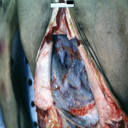

###################################################################
Question:  what is opened abdomen with ischemic appearing intestines bound?
Predicted Answer:  the left ventricle
Actual Answer:  by neoplastic adhesions good but not the best ovarian papillary adenocarcinoma


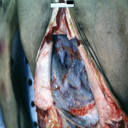

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


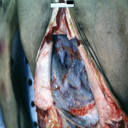

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  peritoneum


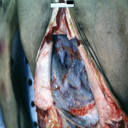

###################################################################
Question:  what does this image show?
Predicted Answer:  the left ventricle
Actual Answer:  a very close - up view of typical gross lesion s


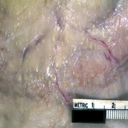

###################################################################
Question:  does this image show a very close - up view of typical gross lesion s?
Predicted Answer:  no
Actual Answer:  yes


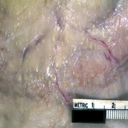

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


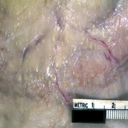

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


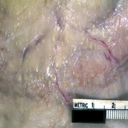

###################################################################
Question:  is opened a bdominal cavity with massive tumor in omentum none apparent in liver nor over peritoneal surfaces gut present?
Predicted Answer:  no
Actual Answer:  no


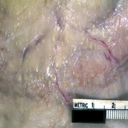

###################################################################
Question:  what is the lumen narrowed by?
Predicted Answer:  the left ventricle
Actual Answer:  eccentric lesion


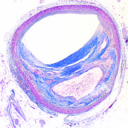

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  peritoneum


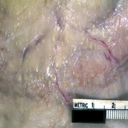

###################################################################
Question:  is peritoneum present?
Predicted Answer:  no
Actual Answer:  yes


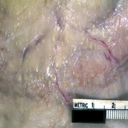

###################################################################
Question:  is tuberculos is present?
Predicted Answer:  no
Actual Answer:  no


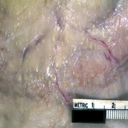

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  tuberculous peritonitis


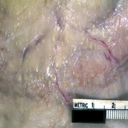

###################################################################
Question:  is tuberculous peritonitis present?
Predicted Answer:  no
Actual Answer:  yes


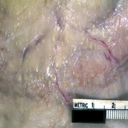

###################################################################
Question:  where is this area in the body?
Predicted Answer:  vasculature
Actual Answer:  abdomen


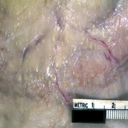

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


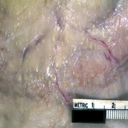

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  peritoneum


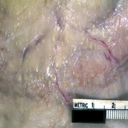

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  tuberculous peritonitis


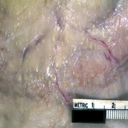

###################################################################
Question:  what does this image show?
Predicted Answer:  the left ventricle
Actual Answer:  massive node enlargement like a lymphoma


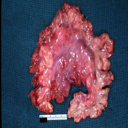

###################################################################
Question:  is the lumen moderately narrowed by this eccentric lesion, which leaves part of the vessel wall unaffected?
Predicted Answer:  no
Actual Answer:  yes


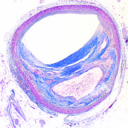

###################################################################
Question:  does this image show massive node enlargement like a lymphoma?
Predicted Answer:  yes
Actual Answer:  yes


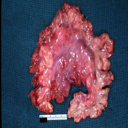

###################################################################
Question:  does abdomen show massive node enlargement like a lymphoma?
Predicted Answer:  no
Actual Answer:  no


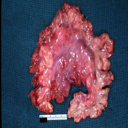

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  abdomen


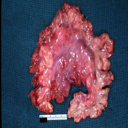

###################################################################
Question:  is abdomen present?
Predicted Answer:  no
Actual Answer:  yes


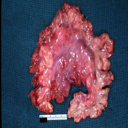

###################################################################
Question:  is tuberculous peritonitis present?
Predicted Answer:  no
Actual Answer:  no


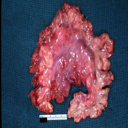

###################################################################
Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  mesentery


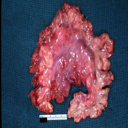

###################################################################
Question:  is mesentery present?
Predicted Answer:  no
Actual Answer:  yes


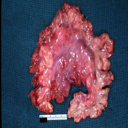

###################################################################
Question:  is carcinomatosis present?
Predicted Answer:  no
Actual Answer:  no


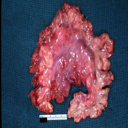

###################################################################


In [38]:
# add batch dimension + move to GPU|
for x in range(100):
    sample = val_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0][1:],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")

Question:  what is present?
Predicted Answer:  the left ventricle
Actual Answer:  cardiovascular


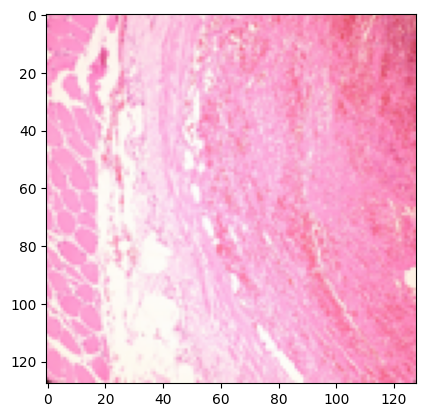

In [39]:
idx = 720
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0][1:],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  does failure to stain reveal a predominantly perivascular cellula r infiltra te that marks positively with anti - cd4 antibodies?
Predicted Answer:  no
Actual Answer:  no


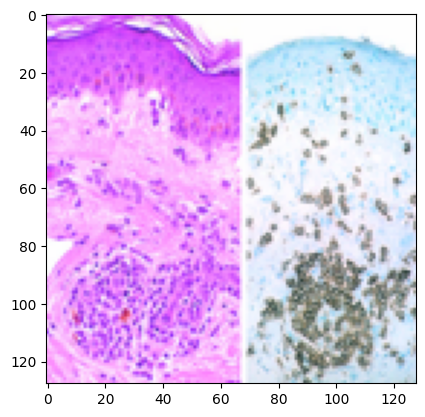

In [40]:
idx = 890
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0][1:],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

Question:  does failure to stain reveal a predominantly perivascular cellula r infiltra te that marks positively with anti - cd4 antibodies?
Predicted Answer:  no
Actual Answer:  no


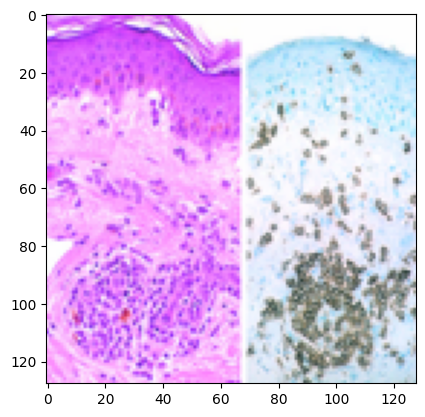

In [41]:
idx = 890
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0][1:],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))